In [ ]:
! pip install torchmetrics lightning -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.0/660.0 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import os
import torch
import numpy as np
import torchvision
from os import path
from torch import nn
from PIL import Image
import torchmetrics as TM
from typing import Sequence
import torchvision.transforms as T
from matplotlib import pyplot as plt
from torchvision.transforms import functional as F
from lightning.pytorch.callbacks import LearningRateMonitor

In [2]:
# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

In [3]:
working_dir = 'data'

# Oxford IIIT Pets Segmentation dataset loaded via torchvision.
pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)

In [4]:
from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2


def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2

In [ ]:
(train_pets_input, train_pets_target) = pets_train_orig[0]

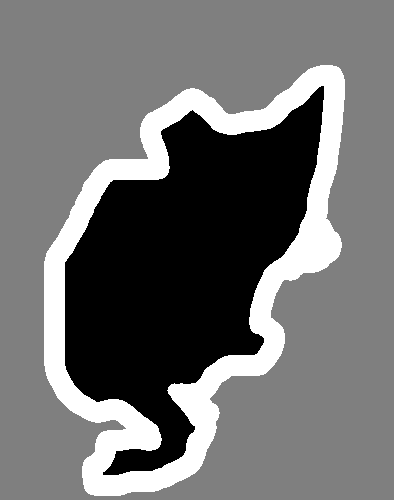

In [ ]:
t2img(trimap2f(train_pets_target))

In [5]:
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)

        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if

        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

In [6]:
# Create a tensor for a segmentation trimap.
# Input: Float tensor with values in [0.0 .. 1.0]
# Output: Long tensor with values in {0, 1, 2}
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=32,
    shuffle=True,
    num_workers=4,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=64,
    num_workers=4,
)

(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32, 1, 128, 128]))

In [7]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, pool=True):
        super().__init__()

        if pool:
          self.maxpool_conv = nn.Sequential(
              nn.MaxPool2d(2),
              DoubleConv(in_channels, out_channels)
          )
        else:
          self.maxpool_conv = nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2, bias=False),
              DoubleConv(out_channels, out_channels)
          )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)





class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, pool=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.pool = pool

        self.inc = (DoubleConv(n_channels, 128))
        self.down1 = (Down(128, 256, pool))
        self.down2 = (Down(256, 512, pool))
        self.down3 = (Down(512, 1024, pool))
        factor = 2 if bilinear else 1
        self.down4 = (Down(1024, 2048 // factor, pool))
        self.up1 = (Up(2048, 1024 // factor, bilinear))
        self.up2 = (Up(1024, 512 // factor, bilinear))
        self.up3 = (Up(512, 256 // factor, bilinear))
        self.up4 = (Up(256, 128, bilinear))
        self.outc = (OutConv(128, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3) # 28x28x512
        x5 = self.down4(x4) # 14x14x1024
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [ ]:
model = UNet(3, 3, bilinear=True, pool=True)

from torchsummary import summary
summary(model.cpu(), (3, 224, 224))

In [8]:
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [16]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import LearningRateMonitor, LearningRateFinder
from lightning.pytorch.callbacks.progress import TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import OneCycleLR


class uNetLightning(pl.LightningModule):
    def __init__(self, n_classes=3, bilinear=False, pool=True, dice=False):
        super().__init__()
        self.dice = dice
        self.n_classes = n_classes

        self.DoubleConv = DoubleConv
        self.OutConv = OutConv
        self.Up = Up
        self.Down = Down
        self.factor = 2 if bilinear else 1

        self.inc = (self.DoubleConv(3, 128))
        self.down1 = (self.Down(128, 256, pool))
        self.down2 = (self.Down(256, 512, pool))
        self.down3 = (self.Down(512, 1024, pool))
        self.down4 = (self.Down(1024, 2048 // self.factor, pool)) #

        self.up1 = (self.Up(2048, 1024 // self.factor, bilinear)) #
        self.up2 = (self.Up(1024, 512 // self.factor, bilinear))
        self.up3 = (self.Up(512, 256 // self.factor, bilinear))
        self.up4 = (self.Up(256, 128, bilinear))

        self.outc = (self.OutConv(128, n_classes))

        self.dice_loss = dice_loss
        self.BCE = nn.CrossEntropyLoss()

        self.save_hyperparameters()


    def forward(self, x):

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return logits

    def model_step(self, batch):

        x, true_masks = batch
        masks_pred = self(x)
        loss = self.evaluate(masks_pred, true_masks)
        return(loss)


    def training_step(self, batch, batch_idx):
        loss = self.model_step(batch)
        self.log('train_loss', loss.item(), prog_bar=True, on_epoch=True, logger=True)
        return loss


    def validation_step(self, batch, batch_idx):
        loss = self.model_step(batch)
        self.log('val_loss', loss.item(), prog_bar=True, on_epoch=True, logger=True)
        return loss


    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
      return(optimizer)


    def evaluate(self, masks_pred, true_masks):
      if self.dice:
        loss = self.dice_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks, self.n_classes).squeeze(1).permute(0, 3, 1, 2).float(),
                              multiclass=True
        )

      else:
        loss = self.BCE(masks_pred, true_masks.squeeze(1))

      return(loss)

In [17]:
trainer = pl.Trainer(
                     log_every_n_steps=1,
                     check_val_every_n_epoch=1,
                     enable_model_summary=True,
                     max_epochs=25,
                     accelerator='auto',
                     devices='auto',
                     strategy='auto',
                     logger=[TensorBoardLogger("logs/", name="uNET-MP+Tr+BCE")],
                     callbacks=[LearningRateMonitor(logging_interval="step")],
                     )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
# ConvTranspose, MaxPool, CrossEntropyLoss
model = uNetLightning(bilinear=True, pool=True, dice=False)
trainer.fit(model, pets_train_loader, pets_test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name  | Type             | Params
--------------------------------------------
0  | inc   | DoubleConv       | 151 K 
1  | down1 | Down             | 885 K 
2  | down2 | Down             | 3.5 M 
3  | down3 | Down             | 14.2 M
4  | down4 | Down             | 18.9 M
5  | up1   | Up               | 23.6 M
6  | up2   | Up               | 5.9 M 
7  | up3   | Up               | 1.5 M 
8  | up4   | Up               | 442 K 
9  | outc  | OutConv          | 387   
10 | BCE   | CrossEntropyLoss | 0     
--------------------------------------------
69.0 M    Trainable params
0         Non-trainable params
69.0 M    Total params
276.124   Total estimated model params size (MB)


Epoch 0:   3%|▎         | 3/115 [00:10<06:47,  3.63s/it, v_num=9, train_loss_step=2.060]

Epoch 1:  40%|████      | 46/115 [02:34<03:51,  3.36s/it, v_num=9, train_loss_step=0.930, val_loss=330.0, train_loss_epoch=0.904] 

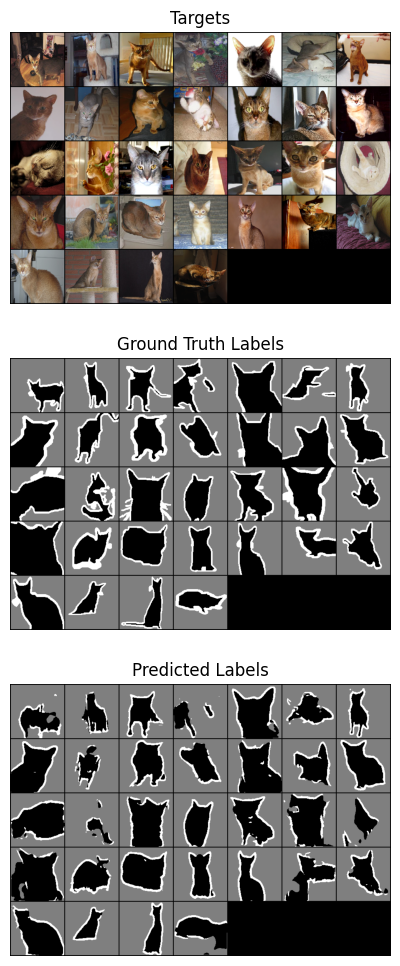

In [44]:
print_test_dataset_masks(model, test_pets_inputs[:21], test_pets_targets[:21], True)

In [ ]:
# ConvTranspose, MaxPool, Dice
model = uNetLightning(bilinear=False, pool=True, dice=True)
trainer.fit(model, pets_train_loader, pets_test_loader)

In [ ]:
# ConvTranspose, StrConv, Cross Entropy
model = uNetLightning(bilinear=False, pool=False, dice=False)
trainer.fit(model, pets_train_loader, pets_test_loader)

In [ ]:
# ConvTranspose, StrConv, Dice
model = uNetLightning(bilinear=False, pool=False, dice=True)
trainer.fit(model, pets_train_loader, pets_test_loader)

In [ ]:
MP+Tr+BCE
MP+Tr+Dice Loss
StrConv+Tr+BCE
StrConv+Ups+Dice Loss

biliniear --> upsample != convtranspose
pool --> maxpool != strconv
dice = dice loss != crossentropy

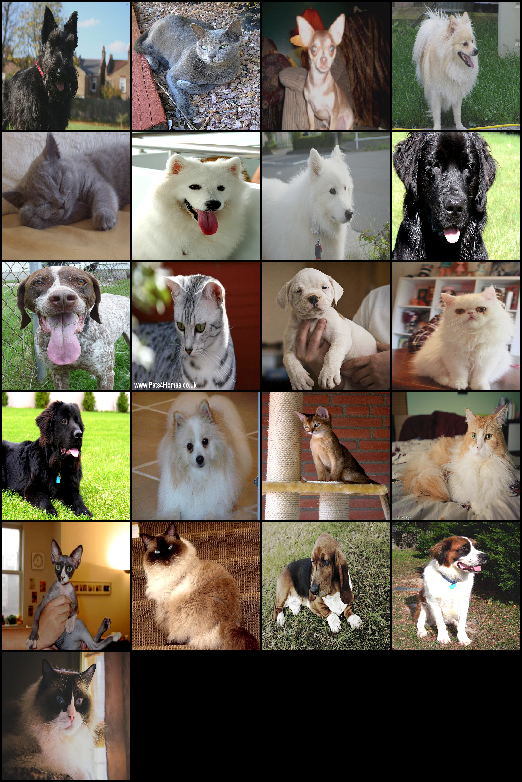

In [ ]:
# Let's inspect some of the images.
pets_input_grid = torchvision.utils.make_grid(test_pets_inputs, nrow=4)
t2img(pets_input_grid)

In [41]:
type(test_pets_inputs), type(test_pets_targets)

(torch.Tensor, torch.Tensor)

In [37]:
def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()

def print_test_dataset_masks(model, test_pets_targets, test_pets_labels, show_plot):
    model.eval()
    model = model.cuda()

    predictions = model(test_pets_targets.cuda())
    # print("Predictions Shape: {}".format(predictions.shape))
    pred = nn.Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)
    # Add a value 1 dimension at dim=1
    pred_labels = pred_labels.unsqueeze(1)
    # print("pred_labels.shape: {}".format(pred_labels.shape))
    pred_mask = pred_labels.to(torch.float)

    # print(f"Accuracy: {accuracy:.4f}")

    # Close all previously open figures.
    close_figures()

    fig = plt.figure(figsize=(10, 12))

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets, nrow=7)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")

    if show_plot is False:
        close_figures()
    else:
        plt.show()

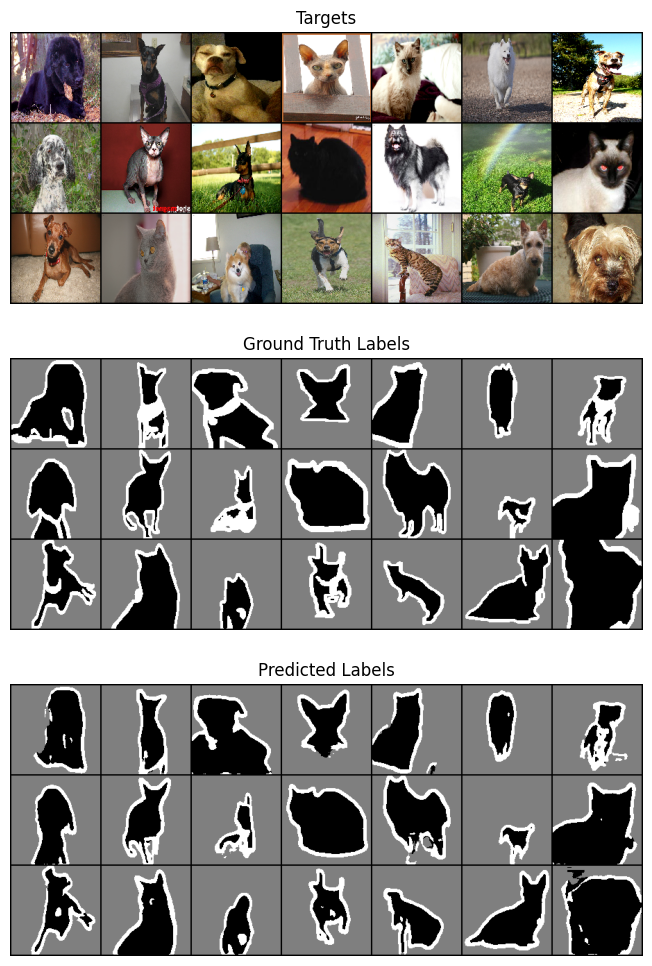

In [ ]:
print_test_dataset_masks(model, test_pets_inputs, test_pets_targets, True)